# Nonlinear model predictive control (NMPC)
In this example we will show how nonlinear model predictive caontrol can be used to performe complex controll tasks such as swinging up and stabilizing the cart pendulum.

<h2 id="tocheading">Table of Contents</h2>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
# Set relative path to parent directory
import sys, os
sys.path.insert(0, os.path.abspath('..'))

In [3]:
# Import environment
from environments.cartPendulum import cartPendulum

env = cartPendulum(mass_cart=1, mass_pendulum=0.1, length_pendulum=1, gravity=9.81)
env.step_size = 0.02

## Modeling
We start out by creating a model of the nonlinear cart pendulum system. In this case we know the mass matrix $M(x)$ and forcing  vector $F(x, u)$ giving the system: $M(x)\dot{x} = F(x, u)$.

In [4]:
import sympy as sp
sp.init_printing()

# Create the symbolic variabels that we will use
m_c, d_c, m_p, l, theta, x, theta_dot, x_dot, u, g = sp.symbols('m_c d_c m_p l theta x theta_dot x_dot u g')

# Compute mass and forcing matrix as given above
mass_matrix = sp.Matrix([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, m_c + m_p, m_p*l*sp.cos(theta)],[0, 0, sp.cos(theta), l]])
forcing_matrix = sp.Matrix([[x_dot], [theta_dot], [m_p*l*theta_dot*theta_dot*sp.sin(theta) - d_c*x_dot + u], [g*sp.sin(theta)]])

We then invert the mass matrix in order to express the dynmics directly as: $\dot{x} = f(x, u)$ and get the following function

In [5]:
# find dx/dt = f(x, u) as specified above
f = sp.simplify(sp.simplify(mass_matrix.inv()@forcing_matrix))
f

⎡                              x_dot                               ⎤
⎢                                                                  ⎥
⎢                              θ_dot                               ⎥
⎢                                                                  ⎥
⎢                    g⋅mₚ⋅sin(2⋅θ)             2                   ⎥
⎢       -d_c⋅x_dot - ───────────── + l⋅mₚ⋅θ_dot ⋅sin(θ) + u        ⎥
⎢                          2                                       ⎥
⎢       ───────────────────────────────────────────────────        ⎥
⎢                                     2                            ⎥
⎢                         m_c + mₚ⋅sin (θ)                         ⎥
⎢                                                                  ⎥
⎢                      ⎛                       2           ⎞       ⎥
⎢g⋅(m_c + mₚ)⋅sin(θ) - ⎝-d_c⋅x_dot + l⋅mₚ⋅θ_dot ⋅sin(θ) + u⎠⋅cos(θ)⎥
⎢──────────────────────────────────────────────────────────────────⎥
⎢                         ⎛       

We now insert the known model parameters $m_c, d_c, m_p, l, g$ and create a python function which we can use to numerically caluclate the function $f(x, u)$

In [6]:
import numpy as np
# substitute in model parameters, and create a function model
parameters = {m_c: env.m_c, m_p: env.m_p, l: env.l, g: env.g, d_c: env.c_d}
dx = sp.utilities.lambdify((x, theta, x_dot, theta_dot, u), f.subs(parameters))

## The sequential approach
In the sequential we directly solve for the cost given an input sequence that is we optimize over the input variabels, and calculate the cost by solving the differential equation during runtime.

In [7]:
# Define weight matrix Q and R
Q = np.diag([5, 10, 1, 1])
R = np.diag([0.01])


# Define prediction horizon and stepsize
N_steps = 10        # Steps
step_size = 0.10    # Seconds

# We define a simulation function
def sim(u, step_size, x0):
    x = np.zeros((len(u) + 1, 4))
    x[0, :] = x0
    # Simulate using euler integration to increase speed
    for t in range(len(u)):
        y = x[t, :]
        for i in range(10):
            y = y + step_size/10*dx(*y, u[t]).flatten()
        x[t+1, :] = y
    return x

# Define cost function
def cost(z):
    x = sim(z.flatten(), step_size, env.x)
    cost = 0
    for xi in x[1:, :]:
        cost += xi.T@Q@xi
    for ui in z:
        cost += ui*R*ui
    return float(cost[0,0])

# define constraints on input
g_1 = lambda x: 100 - x
g_2 = lambda x: x + 100
constraints = ({'type': 'ineq', 'fun': g_1}, {'type': 'ineq', 'fun': g_2})

### Optimization routine
For the optimization routine we will use a sequentila least squares programming algorithem

In [8]:
import scipy.optimize
sequential_nmpc = lambda x : scipy.optimize.minimize(cost, x0 = x, method = 'SLSQP',constraints = constraints)

### Simulation
We now simulate the environment and use solve the nmpc problem to find the ooptimal output

In [9]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import animation
from IPython.display import HTML

# Initial guess for mpc
z = np.zeros(N_steps)

#Simulate the environment for n_steps and save states in X
n_steps = 250
X = np.zeros((n_steps, len(env.x)))
state = env.init([0, -np.pi, 0, 0])
for step in range(n_steps):
    X[step, :] = env.x
    #Run MPC at every step_size time intervall
    if step % round(step_size/env.step_size) == 0:
        print("\rStep: ", step, end="")
        z = np.roll(z, -1) #New guess
        z = sequential_nmpc(z).x
    state = env.step(z[0])
    

# Create the figure
fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-1.1, 1.1), aspect='equal')
line, = ax.plot([], [], lw=2, marker='o', markersize=6)
rect = Rectangle([X[0][0] - 0.2, -0.1],0.4, 0.2, fill=True, color='red', ec='black')
ax.add_patch(rect)

animate = lambda i: (rect.set_xy([X[i,0] - 0.2, -0.1]), 
                     line.set_data([X[i,0], X[i,0] + np.sin(X[i, 1])],[0, np.cos(X[i, 1])]))

# Create and display animation
plt.close()
anim = animation.FuncAnimation(fig, animate, interval = env.step_size*1000, frames = n_steps)

Step:  245

In [10]:
HTML(anim.to_html5_video())

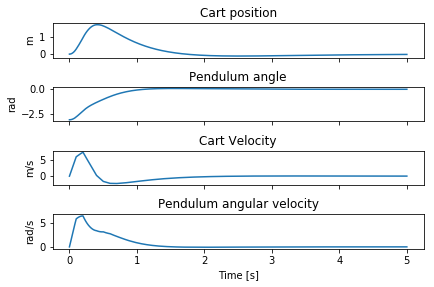

In [11]:
# Plot trajectory
#%matplotlib auto
t = np.linspace(0, n_steps*env.step_size, X.shape[0])
names = ["Cart position", "Pendulum angle", "Cart Velocity", "Pendulum angular velocity"]
units = ["m", "rad", "m/s", "rad/s"]
fig, axarr = plt.subplots(4, sharex=True)
for i in range(4):
    axarr[i].plot(t, X[:, i])
    axarr[i].title.set_text(names[i])
    axarr[i].set_ylabel(units[i])

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.xlabel('Time [s]')
plt.show()

## The simultaneouse approach
In the simultaneouse approach the model constraints are discretized, and the set of nonelinear algebraic equations are treated as equality constraints. 

In [12]:
# Generates G matrix given quadratic penaly Q and R
def gen_g(q, r, n):
    nx = np.shape(q)[0]
    nu = np.shape(r)[0]
    upper = np.concatenate((np.kron(np.identity(n), q), np.zeros([nx * n, nu * n])), axis=1)
    lower = np.concatenate((np.zeros([nu * n, nx * n]), np.kron(np.identity(n), r)), axis=1)
    return np.concatenate((upper, lower), axis=0)

# Define prediction horizon, step size, number of states and number of inputs
N_steps = 10
step_size = 0.1
nx = 4
nu = 1

# Weight matrix Q and R
Q = np.diag([5, 10, 1, 1])
R = np.diag([0.01])

# Compute the optimization problem matrices
G = gen_g(Q, R, N_steps)

# Define objectve functions and constraint functions
cost = lambda x: (x.T@G@x).flatten()[0]
#g_1 = lambda x: 2 - np.abs(x[0:nx*N:nx])
#g_2 = lambda x: 0.1 - np.abs(x[nx*(N-1) + 1])

# We can here define the jacobian which can be supplied to the optimizer
jac = lambda x: np.array(G@x)

# Define equality constraints 
def h_1(x):
    x_sim = sim(x.flatten()[N_steps*nx:], step_size, env.x)
    return np.array(x_sim.flatten()[nx:] - x.flatten()[0:N_steps*nx])

constraints = ({'type': 'eq', 'fun': h_1})

### Optimization routine
For the optimization routine we will use a sequentila least squares programming algorithem, in this case we will have to add  the model equality constraints.

In [13]:
import scipy.optimize
simultaneouse_nmpc = lambda x : scipy.optimize.minimize(cost, x0 = x, method = 'SLSQP',constraints = constraints)

### Simulation
We now simulate the environment and use solve the nmpc problem to find the ooptimal output

In [14]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import animation
from IPython.display import HTML

# Initial guess for mpc
z = np.zeros((N_steps*(nx + nu), 1))

#Simulate the environment for n_steps and save states in X
n_steps = 250
X = np.zeros((n_steps, len(env.x)))
state = env.init([0, -np.pi, 0, 0])
for step in range(n_steps):
    X[step, :] = env.x
    #Run MPC at every step_size time intervall
    if step % round(step_size/env.step_size) == 0:
        print("\rStep: ", step, end="")
        z = simultaneouse_nmpc(z).x
    state = env.step(z.flatten()[N_steps*nx])
    

# Create the figure
fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-1.1, 1.1), aspect='equal')
line, = ax.plot([], [], lw=2, marker='o', markersize=6)
rect = Rectangle([X[0][0] - 0.2, -0.1],0.4, 0.2, fill=True, color='red', ec='black')
ax.add_patch(rect)

animate = lambda i: (rect.set_xy([X[i,0] - 0.2, -0.1]), 
                     line.set_data([X[i,0], X[i,0] + np.sin(X[i, 1])],[0, np.cos(X[i, 1])]))

# Create and display animation
plt.close()
anim = animation.FuncAnimation(fig, animate, interval = env.step_size*1000, frames = n_steps)

Step:  245

In [15]:
HTML(anim.to_html5_video())

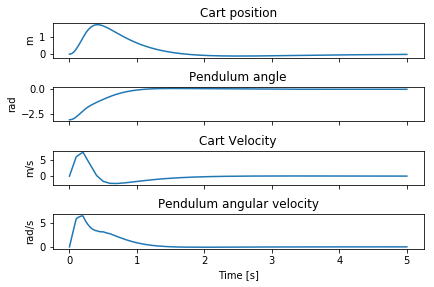

In [16]:
# Plot trajectory
#%matplotlib auto
t = np.linspace(0, n_steps*env.step_size, X.shape[0])
names = ["Cart position", "Pendulum angle", "Cart Velocity", "Pendulum angular velocity"]
units = ["m", "rad", "m/s", "rad/s"]
fig, axarr = plt.subplots(4, sharex=True)
for i in range(4):
    axarr[i].plot(t, X[:, i])
    axarr[i].title.set_text(names[i])
    axarr[i].set_ylabel(units[i])

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.xlabel('Time [s]')
plt.show()